In [6]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np

dt = 0.01  # time step
total_time = 30  # seconds
num_steps = int(total_time / dt)

# trajectory parameters
radius = 5  #  meters
altitude = 5  #  meters
angular_velocity = 0.2  # rad/s

# anchor positions
anchors = np.array([
    [ 10,  10, 0],
    [-10, -10, 0],
    [ 10, -10, 0],
    [-10,  10, 0]
])

positions = np.zeros((num_steps, 3))
velocities = np.zeros((num_steps, 3))
accelerations = np.zeros((num_steps, 3))
distance_measurements = np.zeros((num_steps, len(anchors)))

# simulate 
for i in range(num_steps):
    t = i * dt
    
    # position 
    x = radius * np.cos(angular_velocity * t)
    y = radius * np.sin(angular_velocity * t)
    z = altitude
    positions[i] = [x, y, z]
    
    # velocity
    vx = -radius * angular_velocity * np.sin(angular_velocity * t)
    vy = radius * angular_velocity * np.cos(angular_velocity * t)
    vz = 0
    velocities[i] = [vx, vy, vz]
    
    # acceleration
    ax = -radius * angular_velocity**2 * np.cos(angular_velocity * t)
    ay = -radius * angular_velocity**2 * np.sin(angular_velocity * t)
    az = 0
    accelerations[i] = [ax, ay, az]
    
    # distance to anchors
    for j, anchor in enumerate(anchors):
        distance = np.sqrt((x - anchor[0])**2 + (y - anchor[1])**2 + (z - anchor[2])**2)
        distance_measurements[i, j] = distance

accel_noise_std = 0.02  # std of acceleration noise
dist_noise_std = 0.1  # std of distance measurement noise

accel_noise = accelerations + np.random.normal(0, accel_noise_std, accelerations.shape)

dist_noise = distance_measurements + np.random.normal(0, dist_noise_std, distance_measurements.shape)

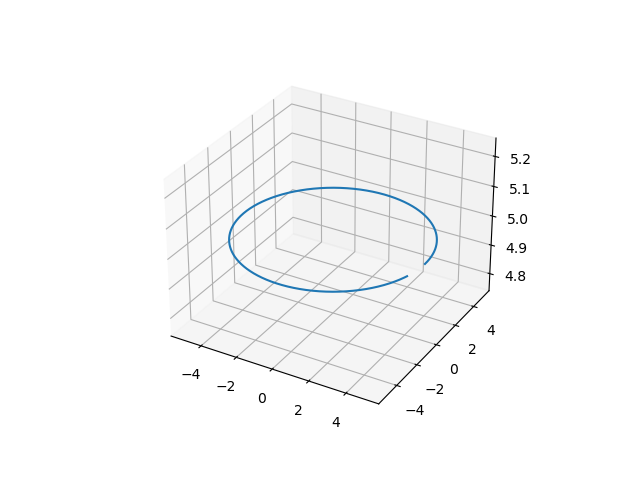

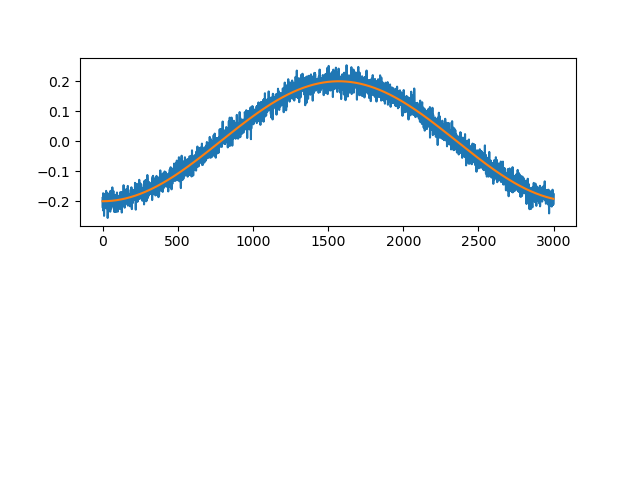

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.plot(positions[:,0], positions[:,1], positions[:,2])

fig2 = plt.figure()
ax1 = fig2.add_subplot(211)
ax1.plot(accel_noise[:,0])
ax1.plot(accelerations[:,0])


In [8]:
import numpy as np

# transition matrix F
def state_transition_matrix(dt):
    return np.array([
        [1, 0, 0, dt, 0, 0, 0.5*dt**2, 0, 0],
        [0, 1, 0, 0, dt, 0, 0, 0.5*dt**2, 0],
        [0, 0, 1, 0, 0, dt, 0, 0, 0.5*dt**2],
        [0, 0, 0, 1, 0, 0, dt, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, dt, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, dt],
        [0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1]
    ])

# measurement model h(x) - distances to anchors and accelerations
def measurement_model(x, anchors):
    distances = np.array([
        np.sqrt((x[0] - anchor[0])**2 + (x[1] - anchor[1])**2 + (x[2] - anchor[2])**2)
        for anchor in anchors
    ])
    accelerations = np.array([x[6], x[7], x[8]])
    return np.concatenate((distances, accelerations))

# jacobian of the measurement model h
def jacobian_h(x, anchors):
    N = len(anchors)
    H = np.zeros((N + 3, len(x)))
    for i, anchor in enumerate(anchors):
        dx = x[0] - anchor[0]
        dy = x[1] - anchor[1]
        dz = x[2] - anchor[2]
        dist = np.sqrt(dx**2 + dy**2 + dz**2)
        H[i, 0] = dx / dist
        H[i, 1] = dy / dist
        H[i, 2] = dz / dist
    H[N,   6] = 1
    H[N+1, 7] = 1
    H[N+2, 8] = 1
    return H

# initial state and covariance
x = np.zeros(9)
x[2] = .1 # drone should be about ground
P = np.eye(9)

# process noise covariance Q
# Q = np.eye(9) * 0.001
Q = np.diag(np.hstack([
    np.ones(3) * 0.00001,
    np.ones(3) * 0.00001,
    np.ones(3) * 0.00001,
]))

# measurement noise covariance R
R = np.eye(7)  
R[:4, :4] *= 0.3**2  # distance noise
R[4:, 4:] *= 0.02**2  # acceleration noise

x_est = []
P_list = []
# Run the EKF
for k in range(len(accel_noise)):
    # prediction
    F = state_transition_matrix(dt)
    if len(x_est) == 0:
        u = accel_noise[0]
    else:
        u = x_est[-1][6:9]
    
    x = F @ x    
    P = F @ P @ F.T + Q

    z = np.concatenate((dist_noise[k], accel_noise[k])) # measurements
    
    # update
    H = jacobian_h(x, anchors)
    S = H @ P @ H.T + R

    K = P @ H.T @ np.linalg.inv(S) # kalman gain
    
    # state estimate
    y = z - measurement_model(x, anchors) # residual
    x = x + K @ y
    
    # covariance estimate
    P = (np.eye(9) - K @ H) @ P

    P_list.append(P)
    x_est.append(x)
x_est = np.array(x_est)
P_list = np.array(P_list)

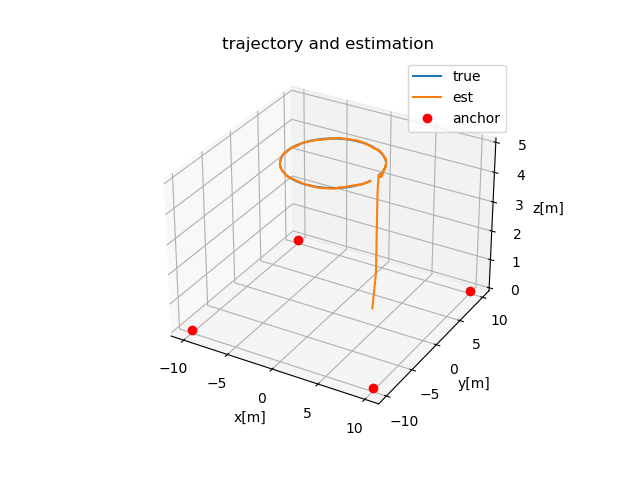

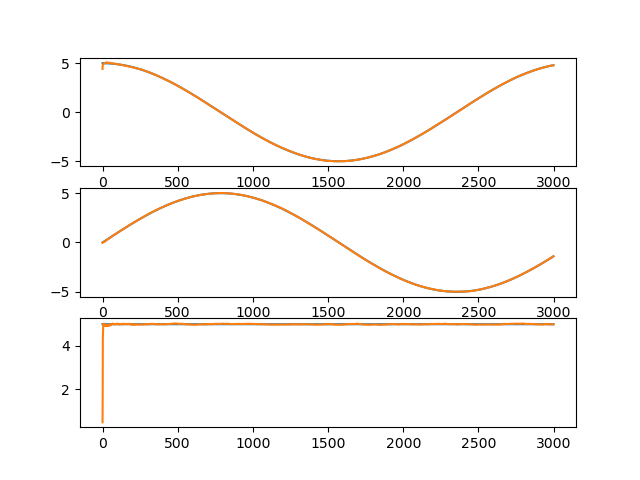

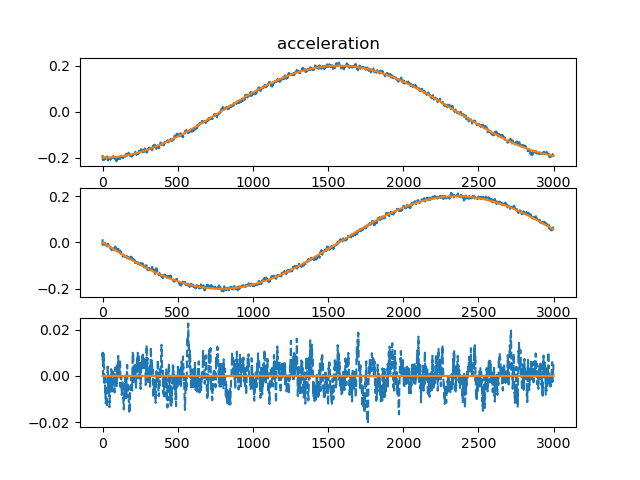

In [9]:
fig3 = plt.figure()
ax = fig3.add_subplot(111, projection="3d")
ax.plot(positions[:,0], positions[:,1], positions[:,2], label="true")
ax.plot(x_est[:,0], x_est[:,1], x_est[:,2], label="est")
ax.plot(anchors[:,0], anchors[:,1], anchors[:,2], 'ro', label="anchor")
ax.set_xlabel("x[m]")
ax.set_ylabel("y[m]")
ax.set_zlabel("z[m]")
ax.legend()
ax.set_title("trajectory and estimation")

fig4 = plt.figure()
ax1 = fig4.add_subplot(311)
ax1.plot(positions[:,0], label="true")
ax1.plot(x_est[:,0], label="est")

ax2 = fig4.add_subplot(312)
ax2.plot(positions[:,1], label="true")
ax2.plot(x_est[:,1], label="est")

ax3 = fig4.add_subplot(313)
ax3.plot(positions[:,2], label="true")
ax3.plot(x_est[:,2], label="est")

fig5 = plt.figure()
ax1 = fig5.add_subplot(311)
# ax1.plot(accel_noise[:,0], label="meas")
ax1.plot(x_est[:,6], "--", label="est")
ax1.plot(accelerations[:,0], label="true")
ax1.set_title("acceleration")

ax2 = fig5.add_subplot(312)
ax2.plot(x_est[:,7], "--", label="est")
ax2.plot(accelerations[:,1], label="true")

ax3 = fig5.add_subplot(313)
ax3.plot(x_est[:,8], "--", label="est")
ax3.plot(accelerations[:,2], label="true")

In [10]:
np.std(positions[:,1] - x_est[:,1])

0.009926705268553937